# Exotic option valuation

### Assumptions:

**Term:** 5 years

**Assets basket:** AAPL (Apple), NVDA (Nvidia), AMD (AMD), INTC (Intel)

**Option's payments:**

*1st year     10% of coupon nominal, if all stocks are above initial prices (WorstOf mechanism), otherwise coupon is remembered for future periods (memory coupon)*

*2nd year     10% of coupon nominal, if all stocks are above initial prices + all memorized coupons*

*3rd year     10% of coupon nominal, if all stocks are above initial prices + all memorized coupons*

*4th year     10% of coupon nominal, if all stocks are above initial prices + all memorized coupons*

*5th year     10% of coupon nominal, if all stocks are above initial prices + all memorized coupons*

**Initial investments:** 1000 USD

**Portfolio assets' weights:** Capital Asset Pricing Model (CAPM)

**Minimal portfolio weight:** 1%

**Volatility estimation:** historical

**Risk-free rate:** 5 year treasury yield (2,65%)

**Correlation of assets:** constant

**Dividend yield assumptions according to forward yield:** NVDA - 0,24%, AAPL - 1,41%, AMD - 0,0%, INTC - 2,36% (Yahoo Finance)

**Look back period for volatility and mean return estimation:** (2016-01-01, 2017-12-31)

### Imported packages and their versions for coherent execution:

python 3.6.1
pandas: 0.22.0
pandas_datareader: 0.6.0
numpy: 1.14.2
matplotlib: 2.2.0
scipy: 1.0.0
sklearn: 0.19.1

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader
import pandas_datareader.data as web
import matplotlib
import matplotlib.pyplot as plt
import random
import scipy
import scipy.linalg as sl
import scipy.optimize as sco
import scipy.stats as scs
import sklearn
from sklearn.preprocessing import RobustScaler

plt.style.use('ggplot')

print('pandas: ' + str(pd.__version__))
print('pandas_datareader: ' + str(pandas_datareader.__version__))
print('numpy: ' + str(np.__version__))
print('matplotlib: ' + str(matplotlib.__version__))
print('scipy: ' + str(scipy.__version__))
print('sklearn: ' + str(sklearn.__version__))

pandas: 0.22.0
pandas_datareader: 0.6.0
numpy: 1.14.2
matplotlib: 2.2.0
scipy: 1.0.0
sklearn: 0.19.1


## Basket class description

**Basket** class inintializes with option's parameters and contains all information from executing methods

**Class' attributes:**

a) *stock_list* - stocks' list 

b) *coupon* -  % of nominal stock value in the corresponding period

c) *maturity* -  option's maturity

d) *memory* - coupons' memory

e) *data_range* - data range for look back

f) *risk_free* - risk-free rate

g) *n_trials* - number of trial in Monte-Carlo simulations

h) *nominal* - initial value of the portfolio 

**The class has 4 methods:**

1) *import_data()* - import data through  data-reader's API

2) *monte_carlo(weights=[], div_yield = [])* - estimates option price, has two parameters: weights - initial weights in the portfolio (if left blank, calculates utilizing CAPM), div_yield - expected dividend yield (if left blank, assumed to be 0)

   The method returns a tuple with a following information:
   
   a) mean option price after all trials
   
   b) Trial's option price
   
   c) stocks' path modelling under risk neutral valuation (no-arbitrage condition)
   
   d) the results of individual stock's positions and the portfolio value in each trial 

3) *greeks(plot = True)* - greeks calculation (using polynomial function and scaled variables): option's delta, gamma and speed

4) *summary_plot()* - summary plot with resulting distributions of option prices and underlying shares

In [2]:
class Basket(object):
    def __init__(self, coupon, maturity, risk_free, nominal, stock_list = [], data_range = [], 
                 memory = True, n_trials = 10):
        self.stock_list = stock_list # list of securities
        self.coupon = coupon # coupon rate %
        self.maturity = maturity # maturity in years
        self.memory = memory # boolean memory of coupon for subsequent years
        self.data_range = data_range # format 'YYYY-MM-DD'
        self.risk_free = risk_free # applicable risk-free rate
        self.trials = n_trials # number of trials in monte carlo simulations
        self.n = len(stock_list) # number of stocks
        self.risk_free_vector = np.full((self.n,), risk_free) #risk free vector
        self.nominal = nominal # USd nominal value of the underlying portfolio 
    '''
    Import initial data for calculation   
    '''
    def import_data(self):
        
        self.data = pd.DataFrame()
        for stock in self.stock_list:
            s = pd.DataFrame(web.DataReader(stock, 'iex', self.data_range[0], self.data_range[1])['close']).rename(columns = {'close': stock}) 
            self.data = pd.concat([self.data, s], axis = 1)
        # convert index to date
        self.data.index = pd.to_datetime(self.data.index)
        # beginning price vector: last close prices
        self.S_beg = self.data.iloc[-1,:] 
        
        def cov_matrix(d = 252): # 252 business days for annualization
            # calculated returns
            self.ret = pd.DataFrame()        
            for stock in self.stock_list:
               s = self.data[stock].pct_change()
               self.ret = pd.concat([self.ret, s], axis = 1)
            
            # drop NA values
            self.ret.dropna(inplace = True)            
            # covariance matrix
            cov_matrix  = np.cov(self.ret.values.T)*d
            # variance
            variance = np.var(self.ret.values.T, axis = 1)*d
        
            return cov_matrix, variance
        
        self.cov_matrix , self.variance = cov_matrix()
        
    # Monte-Carlo simulations
    def monte_carlo(self, weights=[], div_yield = []):
        
        # Vector of dividend yields
        if div_yield == []:
            self.div_yield = np.full((self.n,), 0)
        else:
            if len(div_yield) != self.n:
                raise ValueError('Vector of dividends yield is not equal to number of stocks')
            else:
                self.div_yield = div_yield
            
        #Random walk simulation
        def random_path():
            
            # Cholesky decomposition of covariance matrix
            def cholesky_decomposition():
                L = sl.cholesky(self.cov_matrix)
                    
                return L
            
            # Random normal correlated variables simulation       
            def random_correlated():
                Z = [random.normalvariate(0,1) for i in range(self.n)]
                Y = np.dot(cholesky_decomposition(),Z)
                
                return Y.T
            t = 0
            self.path = np.array(self.S_beg) # beginning vector of prices
            S = self.S_beg
            
            while t < self.maturity: # random walk generator
                # Stocks random path
                S = S*np.exp((self.risk_free_vector -self.div_yield - self.variance/2.)+
                             np.dot(random_correlated(),np.sqrt(self.variance)))
                self.path = np.append(self.path, [S])
                t = t + 1
            self.path = pd.DataFrame(self.path.reshape(self.maturity+1, self.n))  
            
            return self.path
        '''
        Calculate efficient portfolio weights as the optimal portfolio for the option underlyings 
        if weights are not provided
        '''
        # efficient portfolio calculation
        def efficient_portfolio(d = 252): # 252 business days for annualization
            #return of stocks
            ret = [(scs.gmean(self.ret[stock]+1, axis = 0)-1)*d for stock in self.stock_list]
            # bounds of stocks weights in the portfolio       
            bound = (0.01, 1) # minimum weight is 1%
            bounds = tuple(bound for stock in range(self.n))
            args = (ret, self.cov_matrix, self.risk_free)
            
            # annualized portfolio performance
            def portfolio_annualized_performance(weights):
                returns = np.sum(ret*weights)
                std = np.sqrt(np.dot(weights, np.dot(self.cov_matrix, weights)))
                
                return std, returns
            
            # function to minimize        
            def neg_sharpe_ratio(weights, ret, cov_matrix, risk_free):
                p_var, p_ret = portfolio_annualized_performance(weights)
                
                return -(p_ret - self.risk_free) / p_var
            
            constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
            # minimization problem
            result = sco.minimize(neg_sharpe_ratio, self.n*[1/self.n,], 
                                  method = 'SLSQP', bounds = bounds, args = args,
                                  constraints = constraints)
            return result.x
        
        '''
        Choose between provided and optimal weights in the porfolio
        '''
        if weights == []:
            self.weights = efficient_portfolio()
        else:
            if len(weights) != self.n:
                raise ValueError('Weights range does not match number of stocks')
            if np.sum(weights) != 1:
                raise ValueError('Weights sum does not sum to 1')
            else:
                self.weights = weights
        # number of stocks purchased        
        def number_of_stocks():
            number = [self.nominal*self.weights[i]/self.S_beg[i] for i in range(self.n)]
            
            return number
        self.monte_carlo_table = pd.DataFrame()
        self.option_price_table = np.array([])
        self.portfolio = pd.DataFrame()
        
        '''
        Monte Carlo Simulation
        '''
        for i in range(self.trials):
            # names of columns in simulation results
            M = random_path()
            M.columns = [stock +'_' + str(i) for stock in self.stock_list]
            '''
            Price of coupon calculation
            '''
            def price():
                # number of stocks in the portfolio
                n_stocks = number_of_stocks()
                # drop begining prices
                a = np.array(M.iloc[1:,:])
                t = 1
                S = np.array(self.S_beg).reshape(1,self.n)
                # compounded payments
                payments = 0
                # remembered coupons
                remember_coupons = 0
                
                while t < self.maturity:
                    if self.memory == True:
                        # condition that all prices above beginning
                        if (a[t-1:t]>S).all() == True:
                            payments = payments + np.dot(a[t-1:t],n_stocks)*self.coupon/(1+self.risk_free)**t + remember_coupons/(1+self.risk_free)**t
                            remember_coupons = 0
                        else:
                            remember_coupons = np.dot(a[t-1:t],self.weights)*self.coupon
                    else:
                        if (a[t-1:t]>S).all() == True:
                            payments = payments + np.dot(a[t-1:t],n_stocks)*self.coupon/(1+self.risk_free)**t
                        else:
                            pass
                    
                    t +=1
                return payments
            '''
            Final results
            '''
            #option prices
            self.option_price_table  = np.append(self.option_price_table, [price()])
            # average price of option
            self.average_option_price = np.average(self.option_price_table)
            #dataframe of monte_carlo stock simulations            
            self.monte_carlo_table = pd.concat([self.monte_carlo_table, M], axis = 1)
            # dataframe of portfolio simulations
            self.portfolio = pd.concat([self.portfolio, M*number_of_stocks(), 
                                        (M*number_of_stocks()).sum(axis =1).rename('Total_'+ str(i))], axis = 1)            
                        
        return self.average_option_price, self.option_price_table, self.monte_carlo_table, self.portfolio
                       
    '''
    Summary sheet
    '''
    def summary_plot(self):
        print("-"*100)
        print('SUMMARY PLOT')
        print('Option price is {:.2f}'.format(self.average_option_price))
        print('Option in money with probability = {:.2f}'.format(sum([1 for x in self.option_price_table if x>0])/self.trials))
        print('-'*100)
        for stock, ret, std, w, d in zip(self.stock_list, (scs.gmean(self.ret+1, axis=0)-1)*252, 
                                   np.sqrt(self.variance), self.weights, self.div_yield):
            print('Ticker: '+ str(stock) + ', Annualized Return: {:.2%}'.format(ret) + 
                  ', Annualized Volatility: {:.2%}'.format(std) + ', Weight: {:.1%}'.format(w) + 
                  ', Dividend yield: {:.2%}'.format(d))
        
        print("-"*100)
        # graph 1        
        plt.figure(figsize=(10, 7))
        plt.plot(self.data/self.data.iloc[0,:], lw=3, alpha=0.8)
        plt.legend(self.data.columns.values.tolist(), loc='upper left', fontsize=12)
        plt.title('Historical performance')
        plt.ylabel('Historical return, %')
        plt.xlabel('Time scale')
         # graph 2     
        plt.figure(figsize = (10,7))
        plt.hist(self.option_price_table, bins = 20, alpha = 0.8)
        plt.title('Distribution of option prices')
        plt.ylabel('Density')
        plt.xlabel('$')
        #graph 3
        plt.figure(figsize=(10, 7))
        plt.hist(self.portfolio.iloc[-1,self.n::(self.n+1)], bins = 20, alpha = 0.8, color ='b')
        plt.title('Distribution of portfolio values')
        plt.ylabel('Density')
        plt.xlabel('Value of the portfolio, $')
        plt.show()
    
    '''
    Calculation of option greeks
    '''
    def greeks(self, plot = True):
        # Scaling initiated
        rs = RobustScaler()
        scaled_portfolio = rs.fit_transform(self.portfolio.iloc[-1,self.n::(self.n+1)].values.reshape(-1,1)).ravel()
        scaled_option = rs.fit_transform(self.option_price_table.reshape(-1,1)).ravel()
        # polynomial regression applied
        poly = np.polyfit(scaled_portfolio, scaled_option, deg = 3)
        delta, gamma, speed = poly[1:]
        
        if plot==True:
            print("-"*100)
            print('GREEKS')
            print('Option scaled delta is {:.3f}'.format(delta))
            print('Option scaled gamma is {:.3f}'.format(gamma))
            print('Option scaled speed is {:.3f}'.format(speed))
            print("-"*100)
            plt.figure(figsize = (10,7))
            plt.scatter(scaled_portfolio, scaled_option, color ='b')
            plt.xlabel('Scaled portfolio values')
            plt.ylabel('Scaled option values')
            plt.title('Option sensitivities')
            plt.show()
        return poly

Creation of class instance - option

In [3]:
option = Basket(stock_list = ['NVDA', 'AAPL', 'AMD', 'INTC'], data_range = ['2016-01-01', '2017-12-31'],
           coupon = 0.1, maturity = 5, risk_free = 0.0265, nominal = 1000, memory = True, n_trials = 1000) 

In [4]:
option.import_data()

5y
5y
5y
5y


For modeling correlated random variables Choletsky decompositon and standart normal distribution are used: cholesky_decomposition()

In [5]:
option.monte_carlo(div_yield = [0.0024, 0.0141, 0.0, 0.0236]);

----------------------------------------------------------------------------------------------------
SUMMARY PLOT
Option price is 403.54
Option in money with probability = 0.51
----------------------------------------------------------------------------------------------------
Ticker: NVDA, Annualized Return: 90.60%, Annualized Volatility: 43.81%, Weight: 61.1%, Dividend yield: 0.24%
Ticker: AAPL, Annualized Return: 25.71%, Annualized Volatility: 20.94%, Weight: 36.7%, Dividend yield: 1.41%
Ticker: AMD, Annualized Return: 65.91%, Annualized Volatility: 72.92%, Weight: 1.3%, Dividend yield: 0.00%
Ticker: INTC, Annualized Return: 18.40%, Annualized Volatility: 20.03%, Weight: 1.0%, Dividend yield: 2.36%
----------------------------------------------------------------------------------------------------


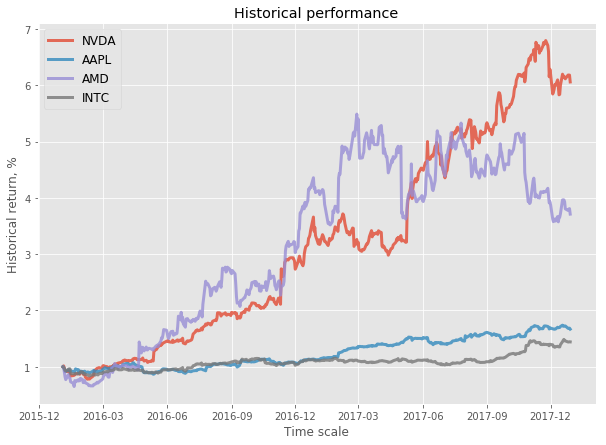

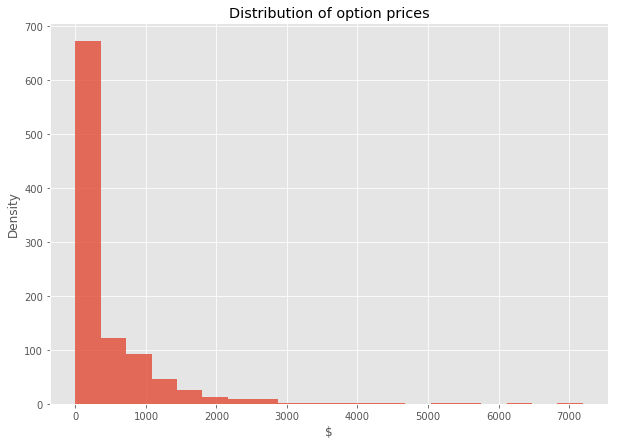

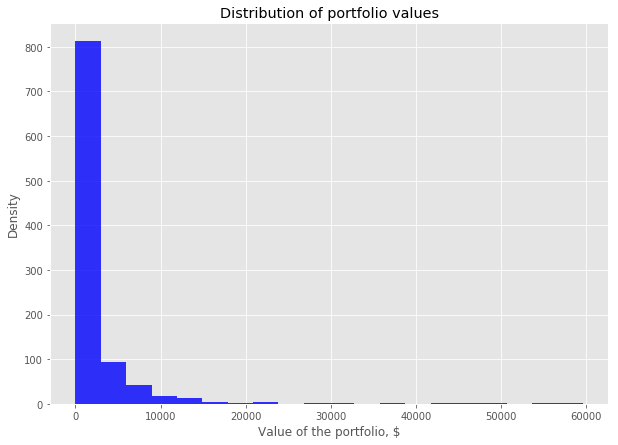

In [6]:
option.summary_plot();

----------------------------------------------------------------------------------------------------
GREEKS
Option scaled delta is -0.037
Option scaled gamma is 0.703
Option scaled speed is 0.135
----------------------------------------------------------------------------------------------------


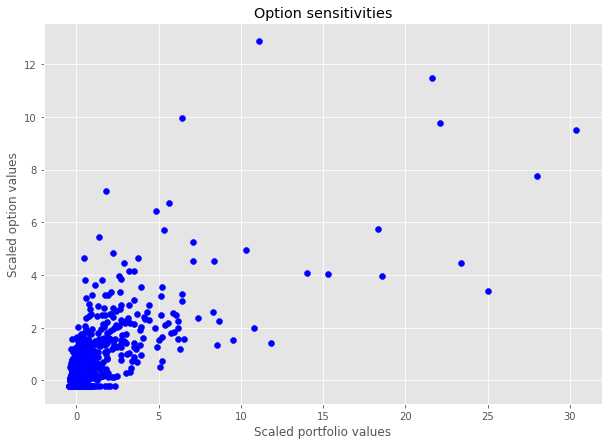

In [7]:
option.greeks();

## Conclusion

1) The assumption of constant assets correlation is used, which is far enough from the reality. In bull and bear markets stocks' correlations may vary significantly.

2) Option prices are the highest under CAPM weights

3) Implied volatilities from options may be a better guide for future voolatilities rather than historic estimations, but lack of free data prevents these calculations.